# Pre-SN Outburst Detection

We use our script `bump_detection.py` to add Gaussian outburst simulations to control light curve flux and determine whether our bump detection algorithm successfully detects these simulations. We determine efficiencies for different Gaussian simulation kernel sizes and peak magnitudes, as well as different algorithm kernel sizes.

Each simulation is recorded and saved into a table corresponding to its peak magnitude. We can load these tables and calculate efficiencies for the previously mentioned parameters by counting the number of successful and failed detections. We additionally calculate contamination for our detection limits using control light curve flux.

All light curves used for the bump analysis must be averaged. We use our download script `download_atlas_lc.py` to query ATLAS machines for SN and control light curves; and our cleaning script `clean_atlas_lc_v2.py` to clean and average them. Please refer to the documentation and scripts on GitHub to do so.

In [1]:
##### LOADING THE AVERAGED SN LIGHT CURVE #####

# Enter the target SN name:
tnsname = '2023ixf'

# Enter the path to the data directory that contains the SN directory:
source_dir = f'/Users/sofiarest/Desktop/Supernovae/data/temp' 

# Enter the path to the parent directory that contains any files to do with bump analysis:
output_dir = f'{source_dir}/{tnsname}/bump_analysis'

# Enter the path to the directory that contains the simulation detection tables:
tables_dir = f'{output_dir}/tables'

# Enter the path to a directory to optionally save any plots:
plots_dir = f'{output_dir}/plots_test' #'/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/2023ixf_paper'

# Enter the filter for this averaged light curve (must be 'o' or 'c'):
filt = 'o'

# Enter the MJD bin size for the averaged light curve (should be in file name):
mjd_bin_size = 1.0 

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS using the API key, TNS ID, and bot name):
discovery_date = 60063.727257
api_key = None
tns_id = None
bot_name = None

# 'Mask' column flags that define bad days in averaged light curve:
#flags = 0x800000

##### LOADING AVERAGED CONTROL LIGHT CURVES #####

# Set to True if you are planning on applying the control light curve cut 
# and have already downloaded the control light curves:
load_controls = True

# Enter the number of control light curves to load:
n_controls = 16 #8

# Enter the source directory of the control light curve files:
controls_dir = f'{source_dir}/{tnsname}/controls'

## Miscellaneous functions (skip this section)

In [2]:
import sys
#sys.path.insert(1,'../')
import pandas as pd
import numpy as np
import copy,math,os
#from scipy import interpolate
from pdastro import pdastrostatsclass
#from asym_gaussian import gauss2lc
from atlas_lc import atlas_lc
from bump_detection import AandB, AnotB, SimDetecLightCurve, EfficiencyTable, Gaussian, flux2mag, mag2flux, in_valid_season #Eruption

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 'Mask' column flags
flags = {'chisquare':0x1, 
		 
		 'uncertainty':0x2,
		 
		 'controls_bad':0x400000,
		 'controls_questionable':0x80000,
		 'controls_x2':0x100,
		 'controls_stn':0x200,
		 'controls_Nclip':0x400,
		 'controls_Ngood':0x800,
		 
		 'avg_badday':0x800000,
		 'avg_ixclip':0x1000,
		 'avg_smallnum':0x2000}

# default plotting styles
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 11)
plt.rc('ytick', labelsize = 11)
plt.rc('legend', fontsize = 9)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['red', 'orange', 'green', 'blue', 'purple', 'magenta'])
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['axes.linewidth'] = 1
marker_size = 30
marker_edgewidth = 1.5
simbump_ls = 'dashed'
fomlimit_ls = 'dotted'

# plotting color scheme
# flux
sn_flux = 'orange'
sn_flagged_flux = 'red'
#ctrl_flux = 'limegreen'
select_ctrl_flux = 'forestgreen' #'darkgreen'
# FOM
sn_fom = 'deeppink'#'magenta'
ctrl_fom = 'cornflowerblue'
select_ctrl_fom = 'mediumblue'

# suppress matplotlib warnings
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")

def save_plot(save_filename=None):
    if not save_filename is None:
        filename = f'{plots_dir}/{save_filename}.png'
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        print(f'Saving plot: {filename}')
        plt.savefig(filename, dpi=200)

## Load the averaged ATLAS light curve

In [3]:
print(f'SN {tnsname}, filter {filt}, MJD bin size {mjd_bin_size} day(s), {n_controls} control light curves')
if not discovery_date is None:
    print(f'SN discovery date: {discovery_date}')
print(f'Source directory (load SN light curve): {source_dir}/{tnsname}')
if load_controls: 
    print(f'Controls directory (load control light curves): {controls_dir}')
print(f'Output directory: {output_dir}')
print(f'Simulation detection tables directory: {tables_dir}')
print(f'Directory for saving plots: {plots_dir}')

SN 2023ixf, filter o, MJD bin size 1.0 day(s), 16 control light curves
SN discovery date: 60063.727257
Source directory (load SN light curve): /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf
Controls directory (load control light curves): /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/controls
Output directory: /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/bump_analysis
Simulation detection tables directory: /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/bump_analysis/tables
Directory for saving plots: /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/bump_analysis/plots_test


In [4]:
if filt != 'o' and filt != 'c': 
	raise RuntimeError('Filter must be "o" or "c"!')

# load cleaned light curve
og_lc = atlas_lc(tnsname=tnsname, discdate=discovery_date)
# load averaged light curve
lc = SimDetecLightCurve(filt, mjd_bin_size, tnsname=tnsname, discdate=discovery_date)

# get discovery date
if lc.discdate is None:
	lc._get_tns_data(tnsname, api_key, tns_id, bot_name)
	og_lc.set_tns_data(lc.ra, lc.dec, lc.discdate)
	
# load cleaned SN and control light curves
og_lc._load(source_dir, filt, 0)

# load averaged SN and control light curves
lc.load(source_dir, num_controls=n_controls)


Loading SN light curve and 0 control light curves...

Loading averaged SN light curve and 16 averaged control light curves...


## Plot cleaned original and averaged pre-SN light curves

In [5]:
# Plot MJD ranges (observation seasons)?:
plot_mjd_ranges = False

# MJD ranges (observation seasons) with valid measurements: 
mjd_ranges = [[57365,57622],
              [57762,57983], 
              [58120,58383], 
              [58494,58741-41], 
              [58822+28,59093], 
              [59184,59445], 
              [59566,59835], 
              [59901,60085]]

# Plot y limits:
ylims = (-300, 400)

# Save plot:
save = True

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/bump_analysis/plots_test/cleaned_avg.png


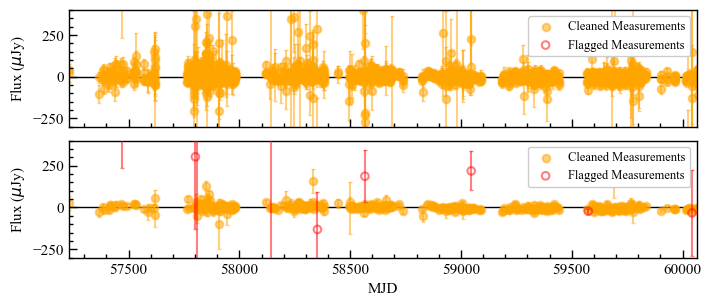

In [6]:
def plot_preSN_lcs(og_lc, lc, ylims=None, plot_mjd_ranges=False, save=False):
    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    fig.set_figwidth(7)
    fig.set_figheight(3)

    # original lc 
    
    if not ylims is None:
        ax1.set_ylim(ylims[0], ylims[1])
    ax1.set_xlim(og_lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax1.minorticks_on()
    ax1.set_xticklabels([])
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(r'Flux ($\mu$Jy)')
    ax1.axhline(linewidth=1, color='k', zorder=0)

    good_ix = og_lc.get_unmasked_ix(flags)
    bad_ix = AnotB(og_lc.get_ix(),good_ix)

    # cleaned
    ax1.errorbar(og_lc.lcs[0].t.loc[good_ix,'MJD'], og_lc.lcs[0].t.loc[good_ix,'uJy'], yerr=og_lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=0)
    ax1.scatter(og_lc.lcs[0].t.loc[good_ix,'MJD'], og_lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Measurements', zorder=0)

    # flagged
    ax1.errorbar(og_lc.lcs[0].t.loc[bad_ix,'MJD'], og_lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=og_lc.lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=sn_flagged_flux, elinewidth=1.5, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax1.scatter(og_lc.lcs[0].t.loc[bad_ix,'MJD'], og_lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label=f'Flagged Measurements', zorder=10)

    # averaged lc

    ax2.set_ylim(ylims[0], ylims[1])
    ax2.set_xlim(og_lc.lcs[0].t.loc[0,'MJD'],discovery_date)
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(r'Flux ($\mu$Jy)')
    ax2.set_xlabel('MJD')
    ax2.axhline(linewidth=1, color='k', zorder=0)

    good_ix = lc.get_unmasked_ix(flags) 
    bad_ix = AnotB(lc.get_ix(),good_ix)

    # cleaned
    ax2.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=0)
    ax2.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Measurements', zorder=0)

    # flagged
    ax2.errorbar(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], yerr=lc.lcs[0].t.loc[bad_ix,'duJy'], fmt='none', ecolor=sn_flagged_flux, elinewidth=1.5, capsize=1.2, c=sn_flagged_flux, alpha=0.5, zorder=10)
    ax2.scatter(lc.lcs[0].t.loc[bad_ix,'MJD'], lc.lcs[0].t.loc[bad_ix,'uJy'], s=marker_size, lw=marker_edgewidth, facecolors='none', edgecolors=sn_flagged_flux, marker='o', alpha=0.5, label=f'Flagged Measurements', zorder=10)

    if plot_mjd_ranges:
        # valid mjd ranges
        for mjd_range in mjd_ranges:
            ax1.axvline(mjd_range[0], color='k', linestyle='dashed')
            ax1.axvline(mjd_range[1], color='k', linestyle='dashed')
            ax2.axvline(mjd_range[0], color='k', linestyle='dashed')
            ax2.axvline(mjd_range[1], color='k', linestyle='dashed')

    ax1.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)
    ax2.legend(loc='upper right', facecolor='white', framealpha=1.0).set_zorder(100)

    if save:
        save_plot(save_filename=f'cleaned_avg')

plot_preSN_lcs(og_lc, lc, ylims=ylims, plot_mjd_ranges=plot_mjd_ranges, save=save)

## Plot pre-SN and selected control light curve

In [7]:
# Select the control light curve to plot:
select_index = 1

# Plot y limits:
ylims = (-150, 150)

# Save plot:
save = True

Saving plot: /Users/sofiarest/Desktop/Supernovae/data/temp/2023ixf/bump_analysis/plots_test/avg_control.png


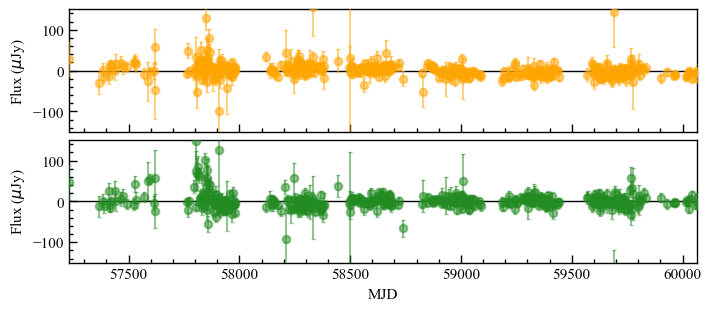

In [8]:
def plot_preSN_control_lcs(lc, select_index, ylims=None, save=False):
	fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
	fig.set_figwidth(7)
	fig.set_figheight(3)

	ax1.set_ylim(ylims[0], ylims[1])
	ax1.set_xlim(lc.lcs[0].t.loc[0,'MJD'],discovery_date)
	ax1.minorticks_on()
	ax1.set_xticklabels([])
	ax1.tick_params(direction='in', which='both')
	ax1.set_ylabel(r'Flux ($\mu$Jy)')
	ax1.axhline(linewidth=1, color='k', zorder=0)

	# pre-SN lc flux
	good_ix = lc.get_unmasked_ix(flags) 
	ax1.errorbar(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], yerr=lc.lcs[0].t.loc[good_ix,'duJy'], fmt='none', ecolor=sn_flux, elinewidth=1.5, capsize=1.2, c=sn_flux, alpha=0.5, zorder=20)
	ax1.scatter(lc.lcs[0].t.loc[good_ix,'MJD'], lc.lcs[0].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=sn_flux, marker='o', alpha=0.5, label=f'Cleaned Pre-SN Light Curve', zorder=20)

	ax2.set_ylim(ylims[0], ylims[1])
	ax2.set_xlim(lc.lcs[0].t.loc[0,'MJD'],discovery_date)
	ax2.minorticks_on()
	ax2.tick_params(direction='in', which='both')
	ax2.set_ylabel(r'Flux ($\mu$Jy)')
	ax2.set_xlabel('MJD')
	ax2.axhline(linewidth=1, color='k', zorder=0)

	# control lc flux
	good_ix = lc.get_unmasked_ix(flags, control_index=select_index) 
	ax2.errorbar(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], yerr=lc.lcs[select_index].t.loc[good_ix,'duJy'], fmt='none', ecolor=select_ctrl_flux, elinewidth=1.5, capsize=1.2, c=select_ctrl_flux, alpha=0.5, zorder=10)
	ax2.scatter(lc.lcs[select_index].t.loc[good_ix,'MJD'], lc.lcs[select_index].t.loc[good_ix,'uJy'], s=marker_size, lw=marker_edgewidth, color=select_ctrl_flux, marker='o', alpha=0.5, label=f'Cleaned Control Light Curve #{select_index}', zorder=10)

	if save:
		save_plot(save_filename=f'avg_control')

plot_preSN_control_lcs(lc, select_index, ylims=ylims, save=save)

## Plot all control light curves

In [9]:
# so that we can try to exclude them
# n-panel plot with panels stacked on top of each other

## Get preliminary $\Sigma_{\rm FOM}$ limits 

For each $\sigma_{kernel}$:
1. Apply a $3\sigma$-cut to its corresponding $\Sigma_{\rm FOM}$ distribution and obtain the standard deviation $\sigma$.
2. Obtain the $3\sigma$ and $5\sigma$ detection limits $\Sigma_{\rm FOM,limit}$.

In [10]:
# Exclude certain control lcs from the analysis:
skip_control_ix = [3]

# Optionally remove bad MJD range(s):
mjd_ranges_remove = [[57365,57622]]

# Sigmas of weighted gaussian rolling sums:
sigma_kerns = [5, 15, 25, 40, 80, 130, 200, 300]

In [11]:
def get_valid_seasons(all_seasons, seasons_to_remove):
    return [season for season in all_seasons if not season in seasons_to_remove]

def get_all_fom_dict(lc, sigma_kerns, skip_control_ix, valid_seasons):
    all_fom_dict = { sigma_kern: None for sigma_kern in sigma_kerns } 
    print(f'Getting all FOM for valid seasons {valid_seasons}...')
    for i in range(len(sigma_kerns)):
        sigma_kern = sigma_kerns[i]
        allfom = pd.Series()
        for control_index in range(1, lc.num_controls+1):
            if control_index in skip_control_ix:
                continue
            lc.apply_rolling_sum(control_index, sigma_kern)
            ix = lc.get_valid_ix(control_index, valid_seasons)
            allfom = pd.concat([allfom, lc.lcs[control_index].t.loc[ix,'SNRsumnorm']], ignore_index=True)
        all_fom_dict[sigma_kern] = allfom
    return all_fom_dict

def get_fom_limits(sigma_kern, all_fom):#, plot=False):
    df = pdastrostatsclass(columns=['SNRsumnorm'])
    df.t['SNRsumnorm'] = all_fom
    df.calcaverage_sigmacutloop('SNRsumnorm', Nsigma=3.0, median_firstiteration=True)
    stdev = df.statparams["stdev"]
    mean = df.statparams["mean"]
    fom_limit_3sig = mean + 3*stdev
    fom_limit_5sig = mean + 5*stdev
    print(f'sigma_kern={sigma_kern}: stdev={df.statparams["stdev"]:0.2f}, 3*stdev={fom_limit_3sig:0.2f}, 5*stdev={fom_limit_5sig:0.2f}')
    return fom_limit_3sig, fom_limit_5sig

def get_all_fom_limits(sigma_kerns, all_fom_dict):
    print(f'Getting FOM limits for sigma_kerns: {sigma_kerns}')
    fom_limits = { sigma_kern: None for sigma_kern in sigma_kerns }
    for sigma_kern in sigma_kerns: 
        fom_limit_3sig, fom_limit_5sig = get_fom_limits(sigma_kern, all_fom_dict[sigma_kern])
        fom_limits[sigma_kern] = [round(fom_limit_3sig, 2), round(fom_limit_5sig, 2)]
    return fom_limits

print(f'Skipping control light curve indices {skip_control_ix}')
print(f'Excluding MJD ranges {mjd_ranges_remove} from analysis')

valid_seasons = get_valid_seasons(mjd_ranges, mjd_ranges_remove)
all_fom_dict = get_all_fom_dict(lc, sigma_kerns, skip_control_ix, valid_seasons)
all_fom_limits = get_all_fom_limits(sigma_kerns, all_fom_dict)
#all_fom_dict_remove = get_all_fom_dict(lc, sigma_kerns, skip_control_ix, mjd_ranges_remove)
#fom_limits_remove = get_all_fom_limits(sigma_kerns, all_fom_dict_remove)

Skipping control light curve indices [3]
Excluding MJD ranges [[57365, 57622]] from analysis
Getting all FOM for valid seasons [[57762, 57983], [58120, 58383], [58494, 58700], [58850, 59093], [59184, 59445], [59566, 59835], [59901, 60085]]...


Getting FOM limits for sigma_kerns: [5, 15, 25, 40, 80, 130, 200, 300]
sigma_kern=5: stdev=1.56, 3*stdev=4.63, 5*stdev=7.75
sigma_kern=15: stdev=2.90, 3*stdev=8.60, 5*stdev=14.39
sigma_kern=25: stdev=3.74, 3*stdev=11.12, 5*stdev=18.60
sigma_kern=40: stdev=4.64, 3*stdev=13.79, 5*stdev=23.07
sigma_kern=80: stdev=6.10, 3*stdev=18.02, 5*stdev=30.22
sigma_kern=130: stdev=7.32, 3*stdev=21.46, 5*stdev=36.10
sigma_kern=200: stdev=8.80, 3*stdev=25.05, 5*stdev=42.66
sigma_kern=300: stdev=10.58, 3*stdev=28.56, 5*stdev=49.72


## Plot preliminary detection limits $\Sigma_{\rm FOM,limit}$

In [12]:
# Plot illustratory histograms:
plot = True

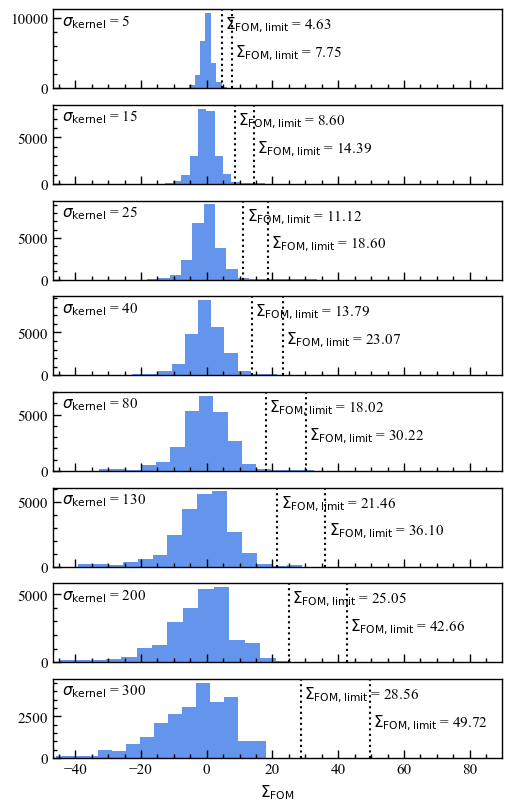

In [13]:
def plot_fom_dists(sigma_kerns, all_fom_dict, all_fom_limits):
    n = len(sigma_kerns)
    fig, axes = plt.subplots(n, constrained_layout=True)
    fig.set_figheight(n)
    fig.set_figwidth(5)

    xlim_lower = np.inf
    xlim_upper = -np.inf
    for sigma_kern in sigma_kerns:
        max_fom = max(max(all_fom_dict[sigma_kern]), all_fom_limits[sigma_kern][1])
        min_fom = min(all_fom_dict[sigma_kern])
        xlim_upper = max_fom if max_fom > xlim_upper else xlim_upper
        xlim_lower = min_fom if min_fom < xlim_lower else xlim_lower

    for i in range(n):
        sigma_kern = sigma_kerns[i]
        all_fom = all_fom_dict[sigma_kern]
        fom_limits = all_fom_limits[sigma_kern]

        axes[i].minorticks_on()
        axes[i].tick_params(direction='in', which='both')
        if i < n-1: 
            axes[i].set_xticklabels([])
        else:
            axes[i].set_xlabel(r'$\Sigma_{\rm FOM}$')
        axes[i].set_xlim(xlim_lower-1, xlim_upper+40)

        axes[i].text(.02, .95, r'$\sigma_{\rm kernel}$ = '+str(sigma_kern), 
                    ha='left', va='top', transform=axes[i].transAxes, fontsize=11)
        axes[i].hist(all_fom, bins=15, color=ctrl_fom)

        ylim_upper = axes[i].get_ylim()[1]
        axes[i].axvline(fom_limits[0], linewidth=1.5, color='k', linestyle=fomlimit_ls)#, label=r'$\Sigma_{\rm FOM, limit} (3\sigma)$ = '+f'{fom_limits[0]:0.2f}') 
        axes[i].text(fom_limits[0]+1, 0.75*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[0]:0.2f}', fontsize=11)
        axes[i].axvline(fom_limits[1], linewidth=1.5, color='k', linestyle=fomlimit_ls)#, label=r'$\Sigma_{\rm FOM, limit} (5\sigma)$ = '+f'{fom_limits[1]:0.2f}') 
        axes[i].text(fom_limits[1]+1, 0.4*ylim_upper, r'$\Sigma_{\rm FOM, limit}$ = '+f'{fom_limits[1]:0.2f}', fontsize=11)

if plot:
    plot_fom_dists(sigma_kerns, all_fom_dict, all_fom_limits)

## Get contamination using preliminary detection limits $\Sigma_{\rm FOM, limit}$

In [14]:
# Save contamination table to tables_dir?:
save = False

In [20]:
def get_n_triggers(lc, control_index, sigma_kern, fom_limit, valid_seasons, verbose=False):
    valid_ix = lc.get_valid_ix(control_index, valid_seasons)

    if control_index == 0:
        preSN_ix = lc.get_pre_SN_ix()
        valid_ix = AandB(preSN_ix, valid_ix)
    """
        lc = pdastrostatsclass()
        lc.t = copy.deepcopy(lcs[0].t.loc[preSN_ix])
    else:
        lc = copy.deepcopy(lcs[control_index])
    """

    lc.apply_rolling_sum(control_index, sigma_kern)#, indices=valid_ix)

    # find any triggers above the fom limit
    count = 0
    mjds = []
    above_lim = False
    for k in valid_ix: 
        if lc.lcs[control_index].t.loc[k, 'SNRsumnorm'] > fom_limit:
            if not above_lim: 
                mjd = lc.lcs[control_index].t.loc[k, "MJDbin"]
                if control_index > 0: # control lc
                    mjds.append(mjd)
                    count += 1
                elif mjd < discovery_date: # MJD must be in pre-SN lc
                    mjds.append(mjd)
                    count += 1
            above_lim = True
        else:
            above_lim = False
    
    if verbose and len(mjds) > 0:
        print(f'sigma_kern {sigma_kern}, fom limit {fom_limit}, control index {control_index}: {count} trigger(s) at mjds {mjds}')
    return count

def get_contamination(lc, sigma_kerns, all_fom_limits, valid_seasons, skip_control_ix, verbose=False, save=False):
    print('Calculating contamination...')

    n_fom_limits = len(sigma_kerns) * len(all_fom_limits[sigma_kerns[0]])
    contam = pd.DataFrame(columns=['sigma_kern', 'fom_limit', 'n_controls_triggered', 'pct_controls_triggered', 'n_triggers'])#+[f'n_controls_{control_index:02d}' for control_index in range(lc.num_controls+1)])
    contam['sigma_kern'] = [np.nan] * n_fom_limits
    contam['fom_limit'] = np.nan
    contam['n_triggers'] = 0
    contam['n_controls_triggered'] = 0
    contam['pct_controls_triggered'] = np.nan

    contam_index = 0
    for sigma_kern in sigma_kerns:
        for fom_limit in all_fom_limits[sigma_kern]:
            contam.loc[contam_index, 'sigma_kern'] = sigma_kern
            contam.loc[contam_index, 'fom_limit'] = fom_limit

            # for SN lc and each control lc
            for control_index in range(lc.num_controls+1):
                if control_index in skip_control_ix:
                    continue
                n_triggers = get_n_triggers(lc, control_index, sigma_kern, fom_limit, valid_seasons, verbose=verbose)
                contam.loc[contam_index, f'n_triggers_{control_index:02d}'] = n_triggers
            
                if control_index > 0 and n_triggers > 0:
                    contam.loc[contam_index, 'n_controls_triggered'] += 1
                    contam.loc[contam_index, 'n_triggers'] += n_triggers
            
            contam.loc[contam_index,'pct_controls_triggered'] = round(100 * contam.loc[contam_index,'n_controls_triggered']/(n_controls-len(skip_control_ix)), 2)
            contam_index += 1
    
    if save:
        contam.to_string(f'{tables_dir}/contamination.txt')
    return contam

contam = get_contamination(lc, sigma_kerns, all_fom_limits, valid_seasons, skip_control_ix, save=save, verbose=True)
print(contam.to_string())

Calculating contamination...
sigma_kern 5, fom limit 4.63, control index 0: 6 trigger(s) at mjds [57844.5, 58260.5, 58330.5, 58596.5, 58684.5, 58850.5]
sigma_kern 5, fom limit 4.63, control index 1: 3 trigger(s) at mjds [57803.5, 57836.5, 58630.5]
sigma_kern 5, fom limit 4.63, control index 2: 4 trigger(s) at mjds [57972.5, 58320.5, 59032.5, 59404.5]
sigma_kern 5, fom limit 4.63, control index 4: 2 trigger(s) at mjds [57907.5, 60084.5]
sigma_kern 5, fom limit 4.63, control index 5: 1 trigger(s) at mjds [57879.5]
sigma_kern 5, fom limit 4.63, control index 6: 4 trigger(s) at mjds [58323.5, 59297.5, 59694.5, 60083.5]
sigma_kern 5, fom limit 4.63, control index 7: 4 trigger(s) at mjds [57828.5, 57896.5, 58295.5, 59242.5]
sigma_kern 5, fom limit 4.63, control index 8: 3 trigger(s) at mjds [57843.5, 57944.5, 58502.5]
sigma_kern 5, fom limit 4.63, control index 9: 1 trigger(s) at mjds [57827.5]
sigma_kern 5, fom limit 4.63, control index 11: 2 trigger(s) at mjds [57858.5, 58685.5]
sigma_kern

## Plot contamination

In [21]:
# Save plot:
save = False

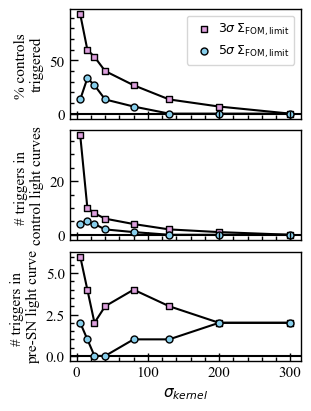

In [22]:
def plot_contamination(contam, sigma_kerns, save=False):
    fig, (ax1, ax2, ax3) = plt.subplots(3, constrained_layout=True)
    fig.set_figwidth(3)
    fig.set_figheight(4)

    fom_limit1_ix = list(np.arange(0, len(sigma_kerns)*2, 2))
    fom_limit2_ix = list(np.arange(1, len(sigma_kerns)*2, 2))

    color_3sigma = 'plum'
    color_5sigma = 'skyblue'
    edgecolor_3sigma = 'k'
    edgecolor_5sigma = 'k'
    markersize = 25

    ax1.set_xticklabels([])
    ax1.minorticks_on()
    ax1.tick_params(direction='in', which='both')
    ax1.set_ylabel(f'% controls \ntriggered',fontsize=11)
    ax1.axhline(color='k', zorder=0)
    ax1.scatter(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'pct_controls_triggered'], 
                color=color_3sigma, edgecolors=edgecolor_3sigma, marker='s', s=markersize, label=r'$3\sigma\: \Sigma_{\rm FOM, limit}$')
    ax1.plot(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'pct_controls_triggered'], color=edgecolor_3sigma, zorder=0)
    ax1.scatter(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'pct_controls_triggered'], 
                color=color_5sigma, edgecolors=edgecolor_5sigma, marker='o', s=markersize, label=r'$5\sigma\: \Sigma_{\rm FOM, limit}$')
    ax1.plot(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'pct_controls_triggered'], color=edgecolor_5sigma, zorder=0)
    ax1.legend(handletextpad=0.1)

    ax2.set_xticklabels([])
    ax2.minorticks_on()
    ax2.tick_params(direction='in', which='both')
    ax2.set_ylabel(f'# triggers in \ncontrol light curves',fontsize=11)
    ax2.axhline(color='k', zorder=0)
    ax2.scatter(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers'], 
                color=color_3sigma, edgecolors=edgecolor_3sigma, marker='s', s=markersize, label=r'$3\sigma\: \Sigma_{\rm FOM, limit}$')
    ax2.plot(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers'], color=edgecolor_3sigma, zorder=0)
    ax2.scatter(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers'], 
                color=color_5sigma, edgecolors=edgecolor_5sigma, marker='o', s=markersize, label=r'$5\sigma\: \Sigma_{\rm FOM, limit}$')
    ax2.plot(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers'], color=edgecolor_5sigma, zorder=0)

    ax3.minorticks_on()
    ax3.tick_params(direction='in', which='both')
    ax3.set_xlabel(r'$\sigma_{kernel}$')
    ax3.set_ylabel(f'# triggers in \npre-SN light curve',fontsize=11)
    #ax3.set_ylim(-0.3, 2.3)
    ax3.axhline(color='k', zorder=0)
    ax3.scatter(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers_00'], 
                color=color_3sigma, edgecolors=edgecolor_3sigma, marker='s', s=markersize, label=r'$3\sigma\: \Sigma_{\rm FOM, limit}$', zorder=5)
    ax3.plot(contam.loc[fom_limit1_ix, 'sigma_kern'], contam.loc[fom_limit1_ix, 'n_triggers_00'], color=edgecolor_3sigma, zorder=0)
    ax3.scatter(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers_00'], 
                color=color_5sigma, edgecolors=edgecolor_5sigma, marker='o', s=markersize, label=r'$5\sigma\: \Sigma_{\rm FOM, limit}$', zorder=5)
    ax3.plot(contam.loc[fom_limit2_ix, 'sigma_kern'], contam.loc[fom_limit2_ix, 'n_triggers_00'], color=edgecolor_5sigma, zorder=0)

    if save:
        save_plot(save_filename='contam')

plot_contamination(contam, sigma_kerns, save=save)

In [18]:
# FOM plot code, with argument to pass MJDs for axvline, and corresponding legend



## Get FOM limits by manipulating contamination

## Plot pre-SN and control light curve FOM

In [19]:
# Select the control light curve to highlight:
select_index = 1